In [1]:
import sys

assert sys.version_info >= (3, 7)

# Nr.1

Exercise: Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyperparameters, such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best SVR predictor perform?

## Loading the data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np

In [3]:
def load_housing_data():
    """
    A tarball is a set of files packaged together into a single file, 
    then compressed using the gzip compression program.
    """
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    # returns a Pandas DataFrame
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Looking at the data

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.shape

(20640, 10)

In [8]:
housing["ocean_proximity"][900:1000]

900    NEAR OCEAN
901     <1H OCEAN
902     <1H OCEAN
903        INLAND
904      NEAR BAY
          ...    
995     <1H OCEAN
996     <1H OCEAN
997        INLAND
998    NEAR OCEAN
999     <1H OCEAN
Name: ocean_proximity, Length: 100, dtype: object

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Function to save the figures as PNGs

In [10]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

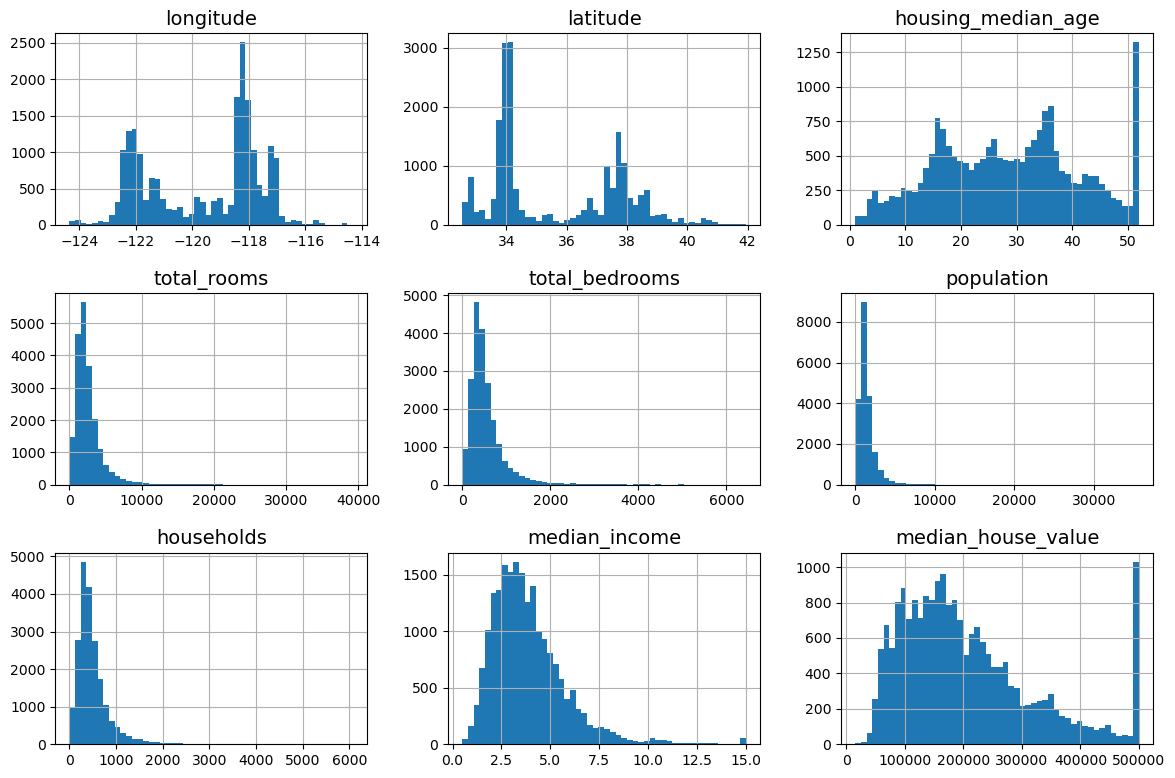

In [11]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # save the figure
plt.show()

# Creating the Test Set

In [12]:
def shuffle_and_split_data(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

# Visualizing the data

In [14]:
# Making a copy of the train set
housing = train_set.copy()

## Geographical Data

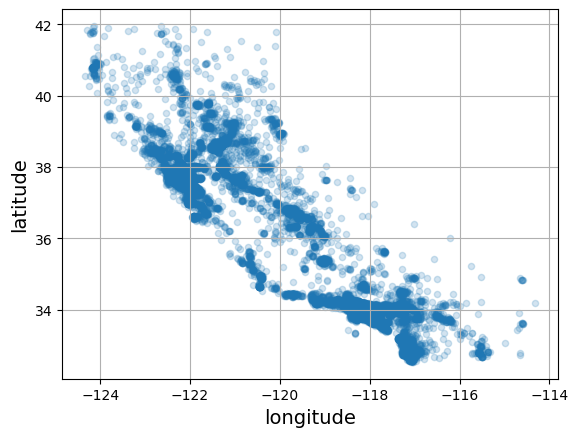

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

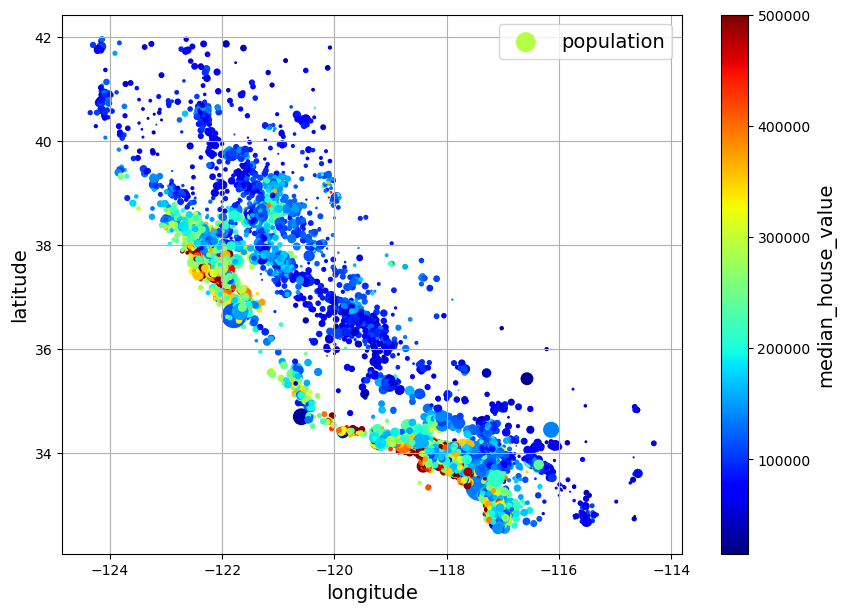

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, 
             label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7))
plt.show()

## Looking for Correlations

In [17]:
# corr() computes the standard correlation coefficient between every pair of attributes.
# Ranges from -1 to +1
# Only do this computation if the dataset is not too large
# Only captures linear correlations!

corr_matrix = housing.corr(numeric_only=True)

In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687013
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
population           -0.025820
longitude            -0.043603
latitude             -0.146324
Name: median_house_value, dtype: float64

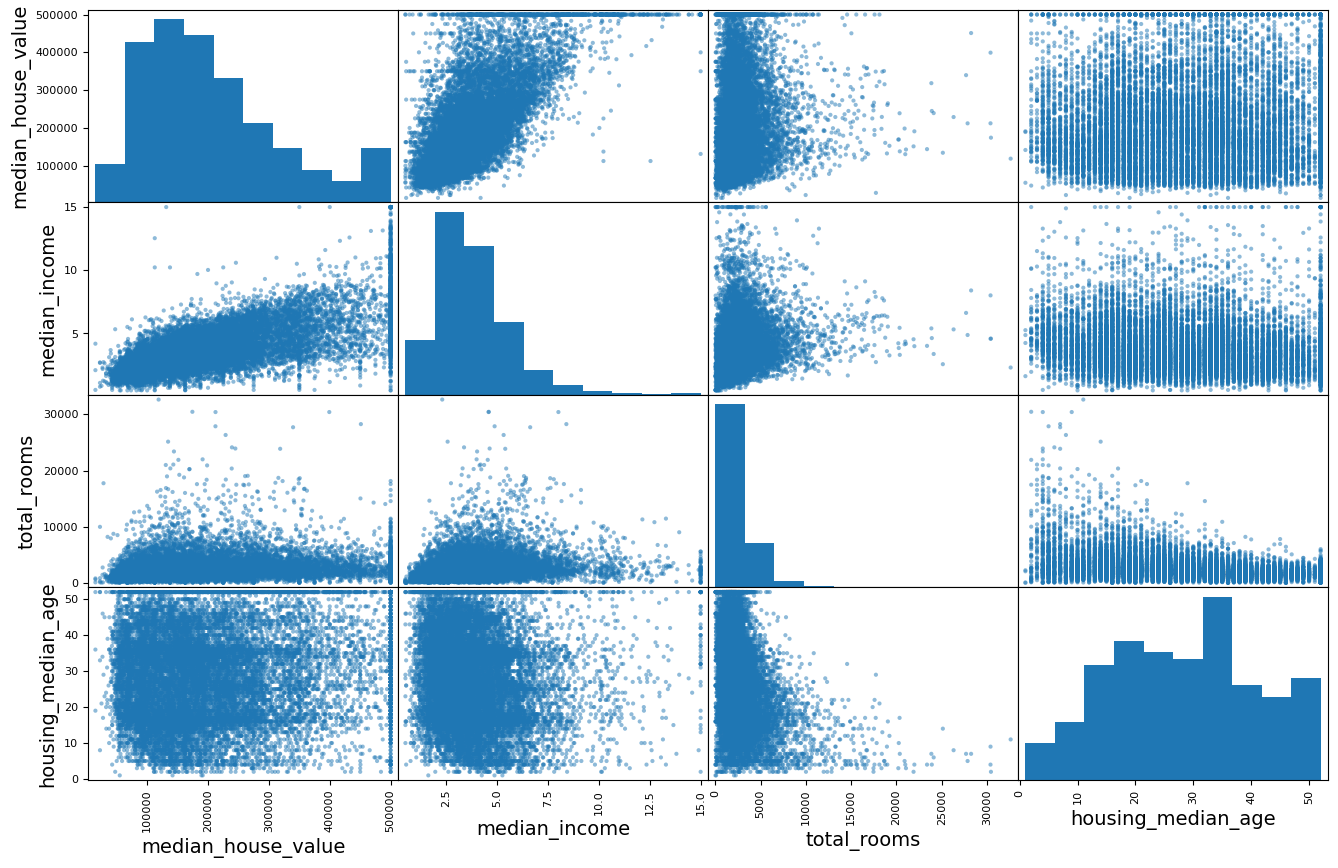

In [19]:
# Pandas scatter_matrix() function plots every numerical attribute against every other numerical attribute 

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(16, 10))
plt.show()

# Preparing the Data for a Machine Learing Model

## Seperating Predictors and Labels

In [20]:
housing_labels = train_set["median_house_value"].copy()
housing = train_set.drop("median_house_value", axis=1)

## Clenaing the Data

### Replacing missing values

In [21]:
# The total_bedrooms attribute has some missing values.
# I am fixing this by inserting the mean of the attribute into the missing values (imputation)

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [22]:
# Better version of the preceding code is the Scikit-Learn class SimpleImputer.

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# Create version of housing dataset with only numerical attributes
housing_numeric = housing.select_dtypes(include=[np.number])

imputer.fit(housing_numeric)

SimpleImputer(strategy='median')

In [23]:
# The Imputer saves the meadian of all attributes in its statistics_ instance variable.
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

In [24]:
# Now using the transform() method will replace all missing values with the norm of its attribute
X = imputer.transform(housing_numeric)

### Handling Text & Categorical Attributes

In [25]:
# the ocean_proximity attribute contains text data

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR BAY
14265,<1H OCEAN
2271,INLAND
17848,NEAR BAY
6252,INLAND
9389,<1H OCEAN
6113,INLAND
6061,<1H OCEAN


In [26]:
# Converting the text to category-ints

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [27]:
housing_cat_encoded[:10]

array([[4.],
       [4.],
       [3.],
       [0.],
       [1.],
       [3.],
       [1.],
       [0.],
       [1.],
       [0.]])

In [28]:
# A list of the corresponding categories is saved in the categories_ instance variable

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [29]:
# The issue with this representation is, that ML algorythms assume that two close values are more similar than two distant ones.
# This may be fine for ordered categories (such as bad, average, good), but this is not the case for ocean_proximity.
# A better approach is to use the scikit-learn's OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_onehot = cat_encoder.fit_transform(housing_cat)

In [30]:
# By default, the output of the OneHotEncoder is a SciPy sparse matrix instead of a NumPy array.

housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [31]:
housing_cat_onehot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [32]:
housing_cat_onehot.shape

(16512, 5)

In [33]:
# The categories are now saved in the OneHotEncoders categories_ instance variable

cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Feature Scaling and Transformation

In [34]:
# Min-Max Scaling (also called Normalization)

from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_minmax_scaled = minmax_scaler.fit_transform(housing_numeric)

In [35]:
# Standartization

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_numeric)

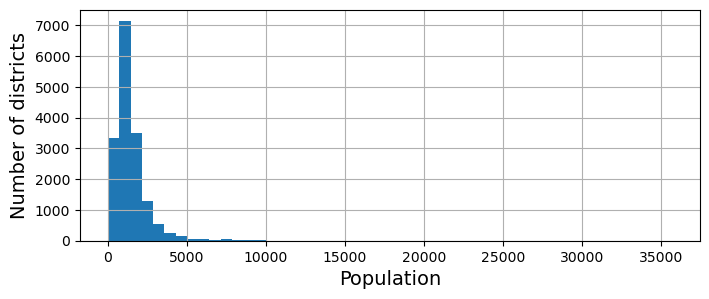

In [36]:
# Long tail attributes

fig, axs = plt.subplots(figsize=(8, 3), sharey=True)
housing["population"].hist(bins=50)
axs.set_xlabel("Population")
axs.set_ylabel("Number of districts")
plt.show()

In [37]:
# Log-Transformer to scale the population attribute

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_population = log_transformer.transform(housing[["population"]])

### Cluster Transformation

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

 ## Putting this into a Pipeline

In [38]:
from sklearn.pipeline import make_pipeline

# Replacing missing values & standartization
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler()) 

# Replacing missing values & 1Hot encoding the categories
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

In [39]:
# Using different transformation-pipelines for differnt types of attributes (columns).
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [40]:
housing_prepared = preprocessing.fit_transform(housing)

In [79]:
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(funtion_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [80]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [81]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape 
# Added 7 extra columns 
# (5 from OneHot encoding the categorical attributes & 

(16512, 24)

In [44]:
housing.shape

(16512, 9)

In [83]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [82]:
preprocessing.output_indices_

{'bedrooms': slice(0, 1, None),
 'rooms_per_house': slice(1, 2, None),
 'people_per_house': slice(2, 3, None),
 'log': slice(3, 8, None),
 'geo': slice(8, 18, None),
 'cat': slice(18, 23, None),
 'remainder': slice(23, 24, None)}

# Training and Evaluating Models

## Linear Regression

In [84]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019FACF04B20>)])),
                ('linearregression', LinearRegression())])

### Making Predictions (inference)

In [85]:
housing_predictions = lin_reg.predict(housing)
print(f"Prediction: \t\t{housing_predictions[:5].round(-2)}") # -2 rounded to the nearest hundred
print(f"Actual Valuation: \t{housing_labels.iloc[:5].values}")

Prediction: 		[263600. 199900. 275900. 281800.  51900.]
Actual Valuation: 	[291000. 156100. 353900. 241200.  53800.]


### Evaluation

#### Root Mean Square Error (RMSE)

In [86]:
from sklearn.metrics import mean_squared_error

lin_reg_mse = mean_squared_error(housing_labels, housing_predictions, squared=False) # With squared to False it is RMSE and not MSE

lin_reg_mse

68743.64454430762

## Decision Tree Regressor

In [88]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019FACF04B20>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

### Evaluation

#### Root Mean Square Error (RMSE)

In [89]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False) # With squared to False it is RMSE and not MSE

tree_rmse

0.0

Tree must be severely overfitting and memorizing every training instance

#### Cross Vlaidation

In [90]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()

count       10.000000
mean     66183.941132
std       2282.370608
min      63020.271955
25%      64186.450172
50%      66124.702662
75%      68487.729634
max      68791.115867
dtype: float64

## Random Forest Regressor

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019F86F26290>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### Evaluation

#### Cross Vlaidation

This cell already takes some time to run (it took ca. 3 min. on my machine)

In [53]:
from sklearn.model_selection import cross_val_score

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

pd.Series(forest_rmses).describe()

count       10.000000
mean     49514.350551
std        927.441031
min      48248.479542
25%      48832.440757
50%      49586.403626
75%      49949.404022
max      51444.370671
dtype: float64

# Fine-Tuning the Model

## Grid Search

In [91]:
# GridSearchCV already includes cross validation

from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000019FACF04B20>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [55]:
grid_search.best_params_

{'random_forest__max_features': 6}

In [56]:
grid_search.cv_results_

{'mean_fit_time': array([ 6.83007669,  9.59520046, 12.50203093]),
 'std_fit_time': array([0.03411073, 0.14658098, 0.06605197]),
 'mean_score_time': array([0.09733399, 0.09466712, 0.09735219]),
 'std_score_time': array([0.00368233, 0.00518547, 0.00310135]),
 'param_random_forest__max_features': masked_array(data=[4, 6, 8],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'random_forest__max_features': 4},
  {'random_forest__max_features': 6},
  {'random_forest__max_features': 8}],
 'split0_test_score': array([-49489.76794318, -49042.37787309, -49668.75571511]),
 'split1_test_score': array([-49787.04878432, -49529.07350618, -49756.03212609]),
 'split2_test_score': array([-49461.15753323, -49198.38237361, -49640.58934167]),
 'mean_test_score': array([-49579.32475358, -49256.61125096, -49688.45906096]),
 'std_test_score': array([147.34674208, 202.91395785,  49.14553555]),
 'rank_test_score': array([2, 1, 3])}

In [57]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,9.595200,0.146581,0.094667,0.005185,6,{'random_forest__max_features': 6},-49042.377873,-49529.073506,-49198.382374,-49256.611251,202.913958,1
0,6.830077,0.034111,0.097334,0.003682,4,{'random_forest__max_features': 4},-49489.767943,-49787.048784,-49461.157533,-49579.324754,147.346742,2
2,12.502031,0.066052,0.097352,0.003101,8,{'random_forest__max_features': 8},-49668.755715,-49756.032126,-49640.589342,-49688.459061,49.145536,3


 ## Randomized Search

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, 
    n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019FAC880970>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019FAC882650>},
                   random_state=42, scoring='neg_root_mean_squared_error')

# Analizing the Best Models 

Looking at the feature importences of the best model

In [94]:
final_model = rnd_search.best_estimator_ # Returns a pipeline object
# "random_forest" was the name defined to the randomForest model inside the pipeline
feature_importances = final_model["random_forest"].feature_importances_ 
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.01, 0.01,
       0.01, 0.02, 0.  , 0.01, 0.02, 0.01, 0.01, 0.01, 0.03, 0.  , 0.01,
       0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

Displaying them next to their attribute names

In [100]:
sorted(
    zip(feature_importances, final_model['preprocessing'].get_feature_names_out()), 
    reverse=True)

[(0.18435207175064458, 'log__median_income'),
 (0.07603002246693451, 'cat__ocean_proximity_INLAND'),
 (0.06820865663414405, 'bedrooms__ratio'),
 (0.05892594638992983, 'rooms_per_house__ratio'),
 (0.04835739126287262, 'people_per_house__ratio'),
 (0.042637670931008474, 'geo__Cluster 32 similarity'),
 (0.02766807512624627, 'geo__Cluster 11 similarity'),
 (0.02402480444829742, 'geo__Cluster 17 similarity'),
 (0.0216166602598974, 'geo__Cluster 4 similarity'),
 (0.016635795121094817, 'geo__Cluster 7 similarity'),
 (0.016243956590843447, 'geo__Cluster 29 similarity'),
 (0.015570913214009226, 'geo__Cluster 34 similarity'),
 (0.014659797969303978, 'geo__Cluster 36 similarity'),
 (0.014547247745954596, 'geo__Cluster 0 similarity'),
 (0.014041181160466492, 'geo__Cluster 44 similarity'),
 (0.012546007025239347, 'geo__Cluster 28 similarity'),
 (0.012219060501809762, 'geo__Cluster 14 similarity'),
 (0.011536945137757897, 'remainder__housing_median_age'),
 (0.011469863342016759, 'geo__Cluster 37 sim

In [101]:
len(
    sorted(
        zip(feature_importances, final_model['preprocessing'].get_feature_names_out()), 
        reverse=True))

59

## Evaluating the Model on the Test Set

In [103]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

42274.843345426474


Computing the 95% confidence interval

In [104]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([39985.95525506, 44446.01379315])

In [109]:
squared_errors.head()

20046    3.882476e+08
3024     8.202496e+06
15663    3.041065e+09
20484    3.291383e+09
9814     1.954170e+09
Name: median_house_value, dtype: float64